In [1]:
#install pyspark
!pip install pyspark

     |████████████████████████████████| 204.2MB 71kB/s 
     |████████████████████████████████| 204kB 49.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=1f848b1d213e38c8f7b3dfc3c5f3963f3381fe972e6f4c24a6bbe5969eb6e04f
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
#mount google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#create the spark session so we can work with spark dataframes
from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [8]:
#from pyspark.sql.functions import concat, col, lit
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [218]:
#Read in CSV files and create raw data frames
games_raw = spark.read.csv("/content/drive/My Drive/NHL Dataset/game.csv",header=True,inferSchema=True)
game_goalie_stats_raw = spark.read.csv("/content/drive/My Drive/NHL Dataset/game_goalie_stats.csv",header=True,inferSchema=True)
game_plays_raw =spark.read.csv("/content/drive/My Drive/NHL Dataset/game_plays.csv",header=True,inferSchema=True)
game_plays_players_raw = spark.read.csv("/content/drive/My Drive/NHL Dataset/game_plays_players.csv",header=True,inferSchema=True)
game_shifts_raw = spark.read.csv("/content/drive/My Drive/NHL Dataset/game_shifts.csv",header=True,inferSchema=True)
game_skater_stats_raw =spark.read.csv("/content/drive/My Drive/NHL Dataset/game_skater_stats.csv",header=True,inferSchema=True)
game_teams_stats_raw = spark.read.csv("/content/drive/My Drive/NHL Dataset/game_teams_stats.csv",header=True,inferSchema=True)
player_info_raw = spark.read.csv("/content/drive/My Drive/NHL Dataset/player_info.csv",header=True,inferSchema=True)
team_info_raw = spark.read.csv("/content/drive/My Drive/NHL Dataset/team_info.csv",header=True,inferSchema=True)

In [220]:
## Create cleaner data frames, removing columns that wont be of interest (time of day,timezone info, venue location, links). 
## Note: Most dataframes do not have info we want to drop

games = games_raw.drop("date_time_GMT","venue_link","venue_time_zone_id","venue_time_zone_offset","venue_time_zone_tz").cache() 
game_goalie_stats = game_goalie_stats_raw.cache()
game_plays = game_plays_raw.cache()
game_plays_players = game_plays_players_raw.cache()
game_shifts = game_shifts_raw.cache()
game_skater_stats = game_skater_stats_raw.cache()
game_teams_stats = game_teams_stats_raw.cache()
player_info = player_info_raw.drop("link").cache()
team_info = team_info_raw.drop("link").cache()

##add point total to player stats
#game_skater_stats = game_skater_stats.withColumn("points", col("goals")+col("assists")).cache()

In [ ]:
def ranked_by_stats_by_season_skater(season,stat,game_type):
  players_ranked_skaters_dtf = game_skater_stats.join(player_info, "player_id").join(games, "game_id").filter("season = {0}".format(season)).filter("type = '{0}'".format(game_type)).select("player_id","{0}".format(stat)).groupBy("player_id").sum("{0}".format(stat)).join(player_info,"player_id").orderBy("sum({0})".format(stat),ascending=False).select(concat("firstName",lit(" "),"lastName").alias("FullName"),"sum({0})".format(stat))
  return players_ranked_skaters_dtf

def skaters_nationalities_by_season(season):
  player_nationality_dtf = game_skater_stats.join(player_info, "player_id").join(games, "game_id").filter("season = {0}".format(season)).select("player_id","nationality").dropDuplicates(["player_id"]).groupBy("nationality").count().withColumnRenamed("count", "player count")
  return player_nationality_dtf

def goalies_nationalities_by_season(season):
  goalie_nationality_dtf = game_goalie_stats.join(player_info, "player_id").join(games, "game_id").filter("season = {0}".format(season)).select("player_id","nationality").dropDuplicates(["player_id"]).groupBy("nationality").count().withColumnRenamed("count", "goalie count")
  return goalie_nationality_dtf 

def nationalities_by_season_total(season):
  player_nationality_dtf = game_skater_stats.join(player_info, "player_id").join(games, "game_id").filter("season = {0}".format(season)).select("player_id","nationality").dropDuplicates(["player_id"]).groupBy("nationality").count().withColumnRenamed("count", "player count")
  goalie_nationality_dtf = game_goalie_stats.join(player_info, "player_id").join(games, "game_id").filter("season = {0}".format(season)).select("player_id","nationality").dropDuplicates(["player_id"]).groupBy("nationality").count().withColumnRenamed("count", "goalie count")
  total_nationality = player_nationality_dtf.join(goalie_nationality_dtf, "nationality").withColumn('total players', col('player count')+col('goalie count')).select("nationality","player count").show()
  return total_nationality_dtf

In [286]:
def PlotGameEvents(team,season,date):
  newDF = games.join(game_team_stats,'game_id').join(team_info,'team_id').filter("season={0}".format(season))
  return newDF
season = '20112012'
team = 'Devils'
date='2012-02-13'
SelectedGameInfo = games.select('game_id','season','date_time','away_team_id','home_team_id').filter("season={0}".format(season)).filter("date_time= '{0}'".format(date)).join(game_teams_stats.select('game_id','team_id'),'game_id').join(team_info,'team_id').filter("teamName = 'Blues'")
#SelectedGameInfo.show()
home_team_info = SelectedGameInfo.select('home_team_id').withColumnRenamed("home_team_id","team_id").join(team_info,'team_id')
away_team_info = SelectedGameInfo.select('away_team_id').withColumnRenamed("away_team_id","team_id").join(team_info,'team_id')
#home_team_info.show()
#away_team_info.show()
SelectedGameData = SelectedGameInfo.select('game_id').join(game_plays.select('game_id','event','team_id_for','st_x','st_y'),'game_id').withColumnRenamed('team_id_for','team_id').filter("event = 'Shot'")
home_team_data = home_team_info.join(SelectedGameData, 'team_id').select('st_x','st_y')
away_team_data = away_team_info.join(SelectedGameData, 'team_id').select('st_x','st_y')
home_team_DF = home_team_data.toPandas().astype(float)
away_team_DF = away_team_data.toPandas().astype(float).apply(lambda x: x*-1)

In [ ]:
pdf = ranked_by_stats_by_season_skater(20172018,"points","R").limit(20).toPandas()

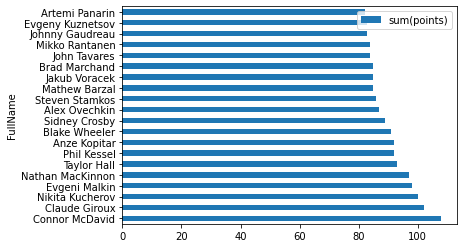

In [ ]:
pdf.plot.barh(x='FullName',y="sum(points)")

In [330]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_rink(ax=None, color='black', lw=2):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()


    center_faceoff = Circle((0, 0), radius=1, linewidth=lw, color='blue', fill=True)
    
    zone_faceoff_1 = Circle((69, 22), radius=1, linewidth=lw, color='red', fill=True)
    zone_faceoff_2 = Circle((-69, 22), radius=1, linewidth=lw, color='red', fill=True)
    zone_faceoff_3 = Circle((69, -22), radius=1, linewidth=lw, color='red', fill=True)
    zone_faceoff_4 = Circle((-69, -22), radius=1, linewidth=lw, color='red', fill=True)

    neutral_faceoff_1 = Circle((20, 22), radius=1, linewidth=lw, color='red', fill=True)
    neutral_faceoff_2 = Circle((-20, 22), radius=1, linewidth=lw, color='red', fill=True)
    neutral_faceoff_3 = Circle((20, -22), radius=1, linewidth=lw, color='red', fill=True)
    neutral_faceoff_4 = Circle((-20, -22), radius=1, linewidth=lw, color='red', fill=True)



    center_circle = Circle((0,0), radius = 15, linewidth=lw, color='blue', fill= False)
    zone_circle_1 = Circle((69,22), radius = 15, linewidth=lw, color='red', fill= False)
    zone_circle_2 = Circle((-69,22), radius = 15, linewidth=lw, color='red', fill= False)
    zone_circle_3 = Circle((69,-22), radius = 15, linewidth=lw, color='red', fill= False)
    zone_circle_4 = Circle((-69,-22), radius = 15, linewidth=lw, color='red', fill= False)                                              

    blue_line1 = Rectangle((-25,-42.5), 0, 85,linewidth=lw,color='blue',fill=False)
    blue_line2 = Rectangle(( 25,-42.5), 0, 85,linewidth=lw,color='blue',fill=False)
    center_line = Rectangle((0,-42.5), 0, 85,linewidth=lw,color='red',fill=False)
   
    goal_line1 = Rectangle((-89,-40.5), 0, 81,linewidth=lw,color='red',fill=False)
    goal_line2 = Rectangle((89,-40.5), 0, 81,linewidth=lw,color='red',fill=False)

    goal_crease1 = Arc((-89,0),8,8,angle=270,theta1=0,theta2=180,color='red')
    goal_crease2 = Arc((89,0),8,8,angle=90,theta1=0,theta2=180,color='red')
    
    top_border = Rectangle((-85,42.5), 170, 0,linewidth=lw,color='black',fill=False)
    bottom_border = Rectangle((-85,-42.5), 170, 0,linewidth=lw,color='black',fill=False)
    left_border = Rectangle((-100,-27), 0, 54,linewidth=lw,color='black',fill=False)
    right_border = Rectangle((100,-27), 0, 54,linewidth=lw,color='black',fill=False)

    bottom_right_corner = Arc((-87.5,-30.1),29,20,angle=135,theta1=22,theta2=155,linewidth=lw)
    top_right_corner = Arc((-87.5,30.1),29,20,angle=45,theta1=22,theta2=155,linewidth=lw)
    top_left_corner = Arc((87.5,30.1),29,20,angle=315,theta1=22,theta2=155,linewidth=lw)
    bottom_left_corner = Arc((87.5,-30.1),29,20,angle=225,theta1=22,theta2=155,linewidth=lw)
  
    
    rink_elements = [center_faceoff,zone_faceoff_1,zone_faceoff_2,zone_faceoff_3,zone_faceoff_4,
                      center_circle,zone_circle_1,zone_circle_2,zone_circle_3,zone_circle_4,
                      blue_line1,blue_line2,center_line,neutral_faceoff_1,neutral_faceoff_2,neutral_faceoff_3,
                      neutral_faceoff_4,goal_line1,goal_line2,goal_crease1,goal_crease2,top_border,bottom_border,
                      left_border,right_border,bottom_right_corner,top_right_corner,top_left_corner,bottom_left_corner]

    # Add the rink elements onto the axes
    for element in rink_elements:
        ax.add_patch(element)

    return ax

def draw_Ozone(ax=None, color='black', lw=2):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()


    
    zone_faceoff_1 = Circle((22, 69), radius=1, linewidth=lw, color='red', fill=True)
    zone_faceoff_2 = Circle((-22, 69), radius=1, linewidth=lw, color='red', fill=True)

    

    zone_circle_1 = Circle((22,69), radius = 15, linewidth=lw, color='red', fill= False)
    zone_circle_2 = Circle((-22,69), radius = 15, linewidth=lw, color='red', fill= False)                                          

    blue_line1 = Rectangle((-42.5,25), 85, 0,linewidth=lw,color='blue',fill=False)
    
    goal_line1 = Rectangle((-40.5,89), 81, 0,linewidth=lw,color='red',fill=False)

    goal_crease2 = Arc((0,89),8,8,angle=180,theta1=0,theta2=180,color='red')
    
    top_border = Rectangle((42.5,25), 0, 60,linewidth=lw,color='black',fill=False)
    bottom_border = Rectangle((-42.5,25), 0, 60,linewidth=lw,color='black',fill=False)

    right_border = Rectangle((-27,100), 54, 0,linewidth=lw,color='black',fill=False)

    bottom_right_corner = Arc((30.1,87.5),29,20,angle=315,theta1=22,theta2=155,linewidth=lw)
    top_right_corner = Arc((-30.1,87.5),29,20,angle=45,theta1=22,theta2=155,linewidth=lw)
  
    
    rink_elements = [zone_faceoff_1,zone_faceoff_2,
                      zone_circle_1,zone_circle_2,
                      blue_line1,
                      goal_line1,goal_crease2,top_border,bottom_border,
                      right_border,bottom_right_corner,top_right_corner]

    # Add the rink elements onto the axes
    for element in rink_elements:
        ax.add_patch(element)

    return ax

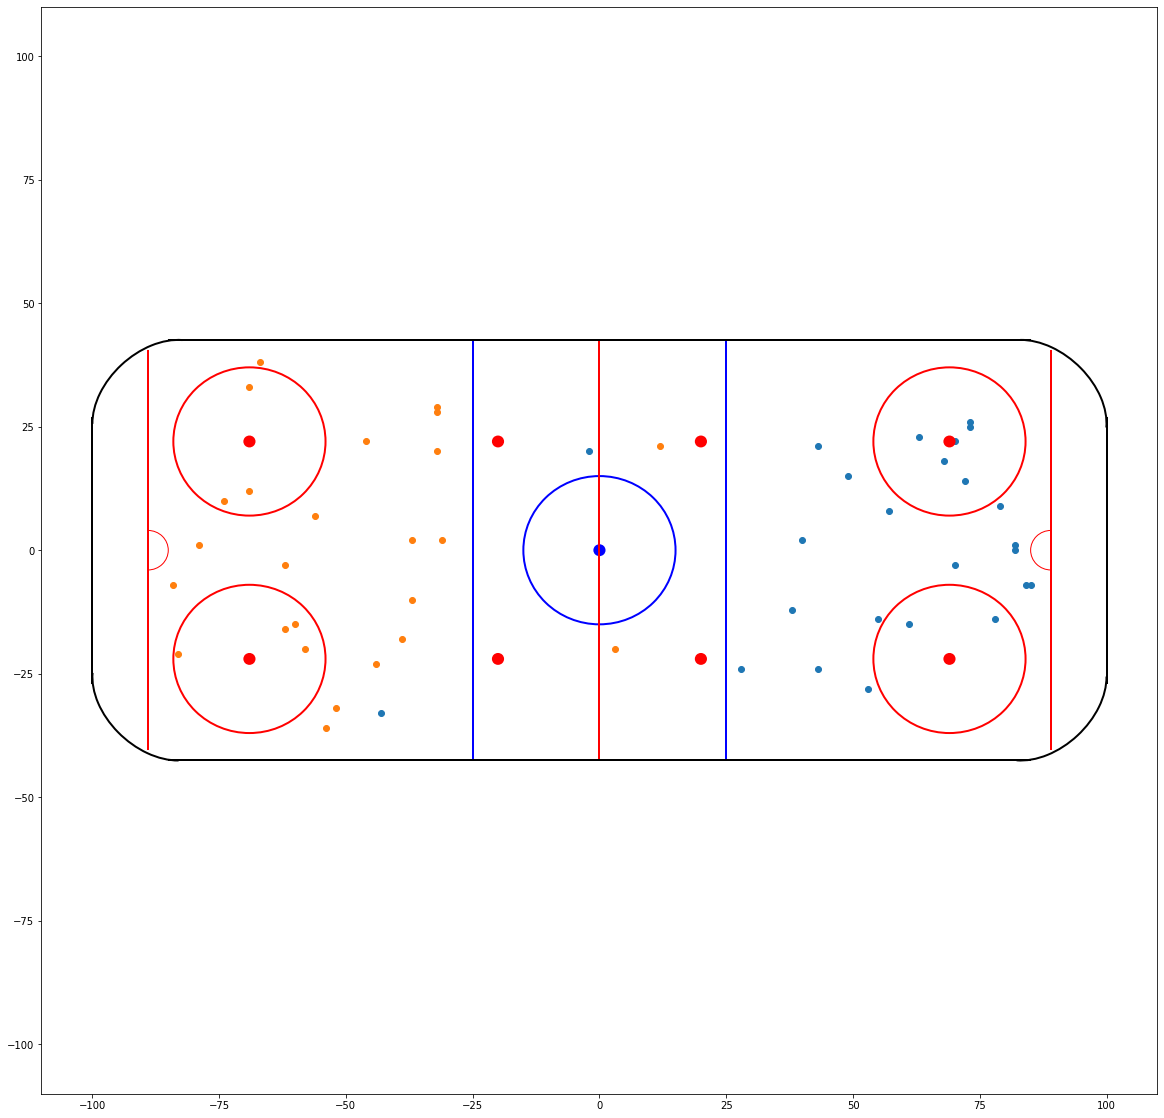

In [309]:
plt.figure(figsize=(20,20))
plt.scatter(home_team_DF.st_x,home_team_DF.st_y)
plt.scatter(away_team_DF.st_x,away_team_DF.st_y)
draw_rink()
plt.xlim(-110,110)
plt.ylim(-110,110)
plt.show()


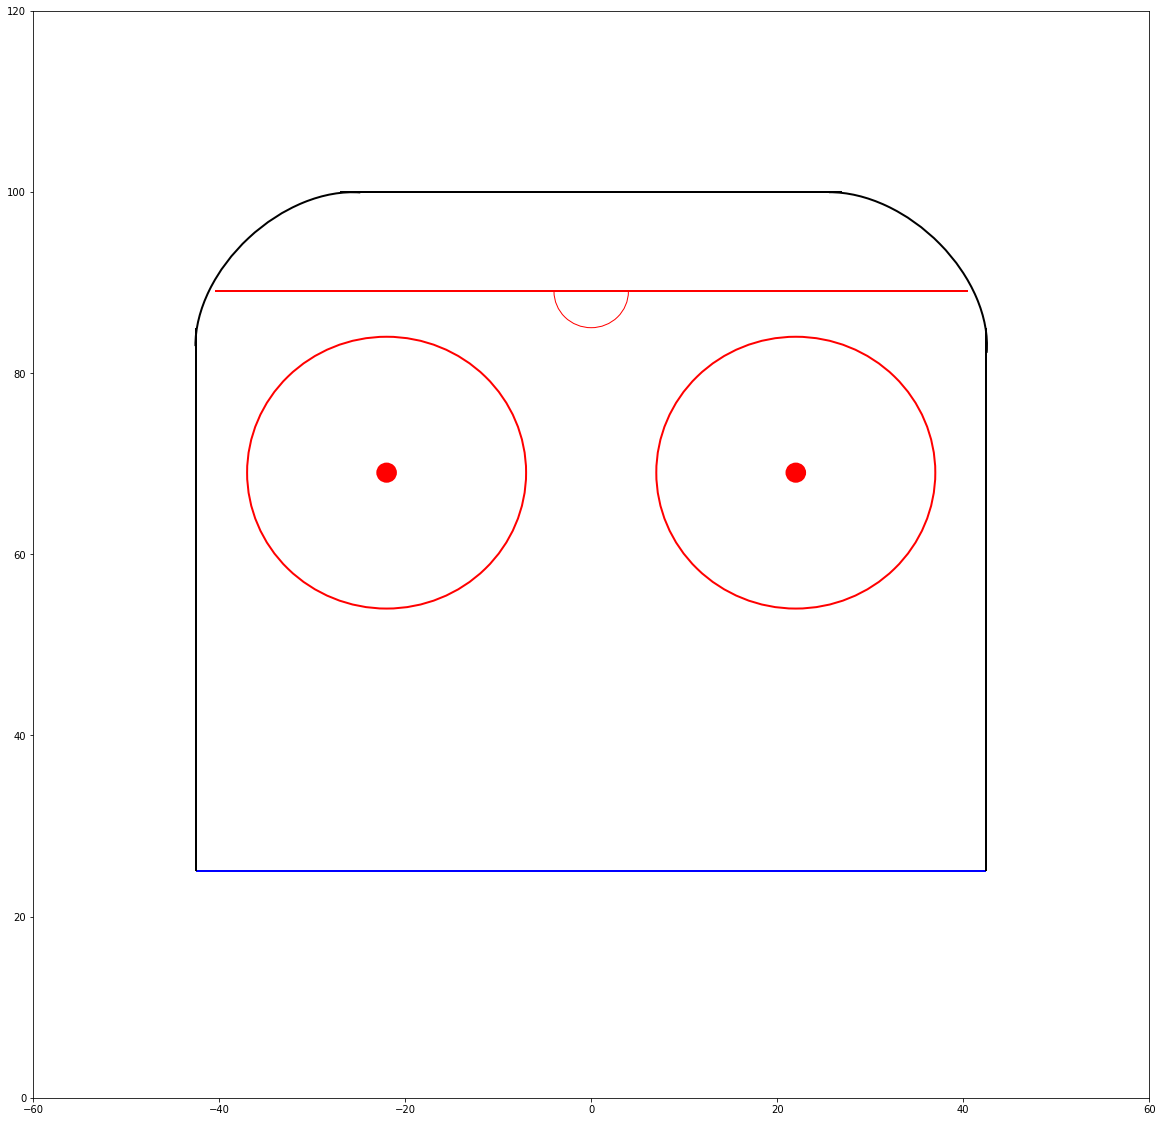

In [336]:
plt.figure(figsize=(20,20))
draw_Ozone()
plt.xlim(-60,60)
plt.ylim(0,120)
plt.show()
